In [99]:

## Data Manipulation
import numpy as np
import pandas as pd
import sqlite3
import pickle

## Authorization
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

## Plotting
import plotly.express as px
import plotly.graph_objects as go
from joypy import joyplot
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from collections import Counter


## Machine Learning
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from tensorflow import keras
from catboost import CatBoostClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


# !pip install sklearn.externals

# Loading Data

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1zVDxQcBrLPkk9Oz-BrdLtKYd_eCW_KBn"}) 
downloaded.GetContentFile('FPA_FOD_20170508.sqlite')  

In [2]:
# conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
# df = pd.read_sql_query("SELECT * from Fires", conn)
states = pd.read_csv('/content/data.csv')

In [7]:
# with open('fires.pickle', 'wb') as f:
# 	pickle.dump(df, f)

In [8]:
# f.download('fires.pkl')       

In [3]:
with open('fires.pickle', 'rb') as f:
 	df = pickle.load(f)

In [4]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


# Preprocessing
## Removing extra/useless features, main reasons for removing these features:

*   More than 50% of the values are missing. Such as: FIRE_CODE, MTBS_ID, and COMPLEX_NAME.
*   Repetetive information; two features that resembles the same thing where one is a string and the other is an ID or a meaningless number. Such as: OWNER_CODE.
*   Enormous Unique values. Such as: FIRE_NAME.
*   Irrelevant Feature; irrelevant for our target. Such as: FPA_ID.

In [5]:
new_df = df.drop(columns=["FOD_ID", "NWCG_REPORTING_UNIT_ID", "NWCG_REPORTING_UNIT_NAME",
             "SOURCE_REPORTING_UNIT", "SOURCE_REPORTING_UNIT_NAME", "LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID",
             "FIRE_CODE", "FIRE_NAME", "ICS_209_INCIDENT_NUMBER", "ICS_209_NAME", "MTBS_ID", "MTBS_FIRE_NAME", 
             "COMPLEX_NAME", "OWNER_CODE", "COUNTY", "FIPS_CODE", "FIPS_NAME", "Shape", "FPA_ID"])
 

In [6]:
del df

Processing Time Features:

In [7]:
new_df['DATE'] = pd.to_datetime(new_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
new_df['MONTH'] = pd.DatetimeIndex(new_df['DATE']).month
new_df['DAY_OF_WEEK'] = pd.DatetimeIndex(new_df['DATE']).dayofweek
new_df['CONT_DATE'] = pd.to_datetime(new_df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
new_df['CONT_MONTH'] = pd.DatetimeIndex(new_df['CONT_DATE']).month
new_df['CONT_DAY_OF_WEEK'] = pd.DatetimeIndex(new_df['CONT_DATE']).dayofweek
new_df["BURNING_DURATION_PER_DAY"] = (new_df["CONT_DATE"] - new_df["DATE"]).dt.days

Keeping the new time features that we created and removing the old ones:

In [8]:
new_df = new_df.drop(columns=["DISCOVERY_DATE", "DISCOVERY_DOY", "CONT_DATE", "CONT_DOY", "DATE", "DISCOVERY_TIME", "CONT_TIME"])

creating a df for visualization - vis_df:

In [9]:
vis_df = new_df.copy()

Label Encoding FIRE_SIZE_CLASS since it is an ordinal categorical feature:

In [10]:
le = preprocessing.LabelEncoder()
new_df["FIRE_SIZE_CLASS"] = le.fit_transform(new_df["FIRE_SIZE_CLASS"])

Taking log of FIRE_SIZE since its distribution is centered around 0; we do log(1+FIRE_SIZE) because FIRE_SIZE could be less than 1.
note: we don't do ths on vis_df.

In [11]:
new_df["FIRE_SIZE"] = np.log(1 + (new_df["FIRE_SIZE"]))

Creating a dictionary that labels each cause whether it's human related or not:

In [12]:
vis_df['STAT_CAUSE_CODE'] = vis_df['STAT_CAUSE_CODE'].astype(int)

cause_dict = {
    1:{'man_made':0, 'label':'Lightning'},
    2:{'man_made':1, 'label':'Equipment Use'},
    3:{'man_made':1, 'label':'Smoking'},
    4:{'man_made':1, 'label':'Campfire'},
    5:{'man_made':1, 'label':'Debris Burning'},
    6:{'man_made':1, 'label':'Railroad'},
    7:{'man_made':1, 'label':'Arson'},
    8:{'man_made':1, 'label':'Children'},
    9:{'man_made':2, 'label':'Miscellaneous'},
    10:{'man_made':1, 'label':'Fireworks'},
    11:{'man_made':1, 'label':'Powerline'},
    12:{'man_made':1, 'label':'Structure'},
    13:{'man_made':2, 'label':'Missing/Undefined'},
}

Grouping cause by fire size(sum/max/mean):

In [13]:
fires_by_cause = vis_df.groupby(by = ['STAT_CAUSE_CODE']).agg({'OBJECTID':'count', 'FIRE_SIZE':['sum', 'max', 'mean']})

# Visualizations:

## Distribution of Fires by Cause:

In [14]:
fig = px.bar(x = [cause_dict[i]['label'] for i in fires_by_cause.index], y = fires_by_cause['OBJECTID']['count']).update_xaxes(categoryorder="total ascending")
fig.update_layout(title = 'Distribution of Fires by Cause', 
                 xaxis_title = 'Cause of Fire',
                 yaxis_title = 'Count of Fires', 
                 title_x = 0.5)
fig.show()

We can see that Debris Burning, Miscellaneous, Arson and Lightning are the leading causes.

This tells us that most of the known causes are man_made.
 

## Area of Fires by Cause:

In [15]:
fig = px.bar(x = [cause_dict[i]['label'] for i in fires_by_cause.index], y = fires_by_cause['FIRE_SIZE']['sum']).update_xaxes(categoryorder="total ascending")
fig.update_layout(title = 'Area of Fires by Cause', 
                 xaxis_title = 'Cause of Fire',
                 yaxis_title = 'Burned Area (by acres)',
                 title_x = 0.5)
fig.show()

We see that lightning is by far the leader in causing large fires that burn large areas. This makes sense because those fires likely take time to discover and get under control. Fires that are caused by human causes are likely reported earlier and easier to access. They are also likely considered higher priority since they may threaten homes and buildings.

Text(0.5, 1.0, 'Median of Area Size by Fire Cause')

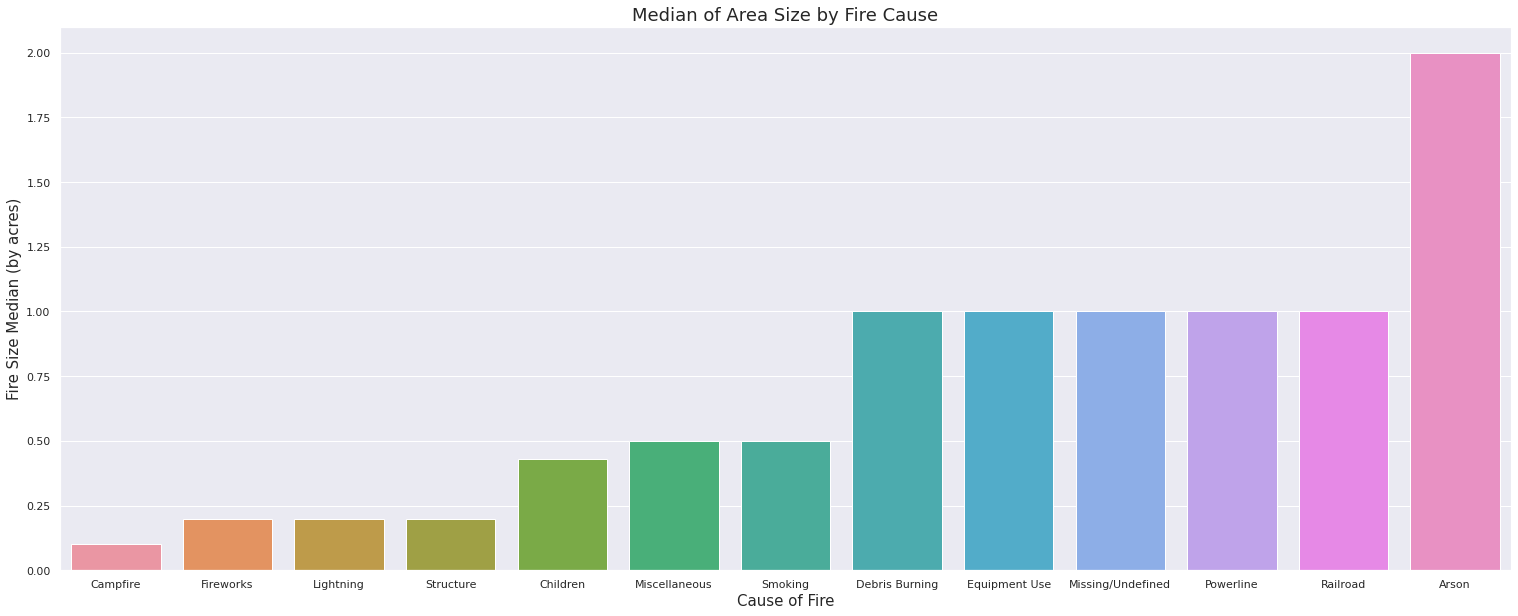

In [16]:
temp_df = vis_df.groupby(["STAT_CAUSE_DESCR"]).median()
sns.set(rc={'figure.figsize':(26,10)})
ax = sns.barplot(x=temp_df.index, y=temp_df["FIRE_SIZE"], order=temp_df.sort_values('FIRE_SIZE').index)
ax.tick_params(axis='x')
ax.set_xlabel("Cause of Fire", fontsize=15)
ax.set_ylabel("Fire Size Median (by acres)", fontsize=15)
ax.set_title("Median of Area Size by Fire Cause", fontsize=18)

When we look at the Median of Area Size we can see a huge decrease in the Lightning cause and an increase in the rest of the human causes.
Intuitively (Hypothesis), this happens because some lightning incidents happen in an uninhibatant areas. Such as Alaska. Which means people wouldn't discover those incidents fast. Therefore, the fire exapnds.
In other words, using Median on fire size removes outliers.

We give color for each cause to see each cause on a map

In [17]:
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'orange',
    'beige',
    'yellow',
    'darkgreen',
    'darkblue',
    'purple',
    'pink',
    'lightgray',
    'green',
    'black'
]
causes = vis_df['STAT_CAUSE_DESCR'].unique()
colors_cause_dic = {causes[i]: colors[i] for i in range(len(causes))}

In the following map we ignore Miscellaneous and Missing/Undefined causes since they aren't helpful for our target as we explained before.

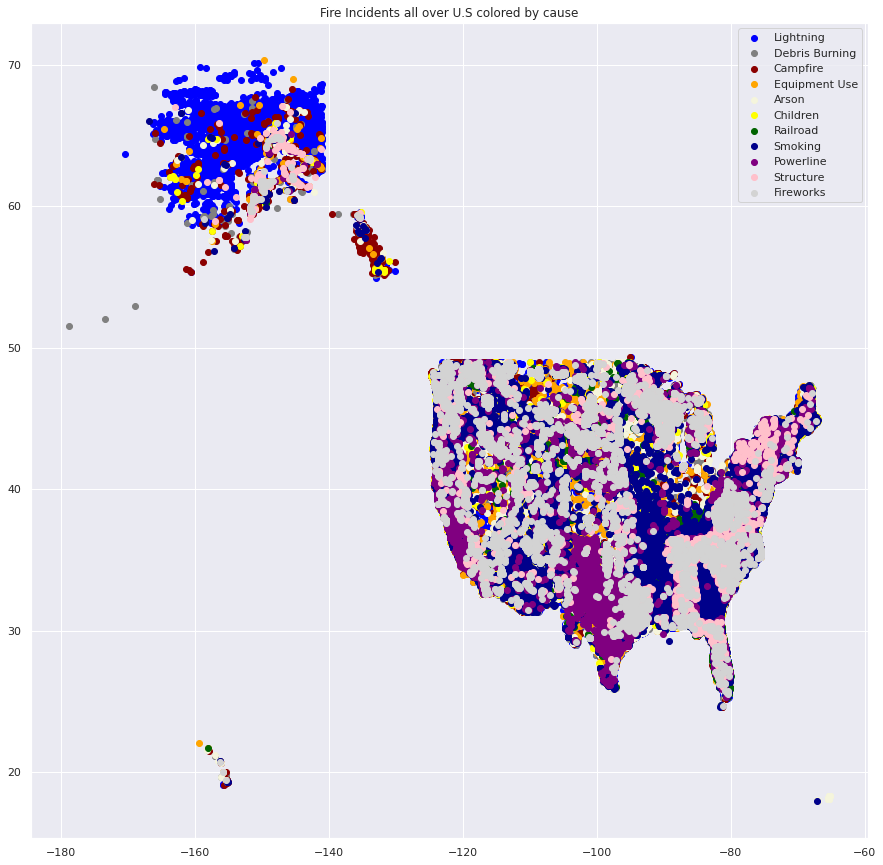

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))
for cause in colors_cause_dic.keys():
  if cause in ["Miscellaneous", "Missing/Undefined"]:
    continue
  ax.scatter(x=vis_df[vis_df['STAT_CAUSE_DESCR'] == cause]['LONGITUDE'],
             y=vis_df[vis_df['STAT_CAUSE_DESCR'] == cause]['LATITUDE'], 
             c=colors_cause_dic[cause], label=cause)
ax.legend()

plt.title("Fire Incidents all over U.S colored by cause")
plt.show()

We can see that most Alaska wildfire causes are Lightning. 

Now we try to distinguish the lightning outliers,look at their burning duration and in which state they occures to test our hypothesis.

Text(0.5, 1.0, 'Area of Fires for Lightning Incidents')

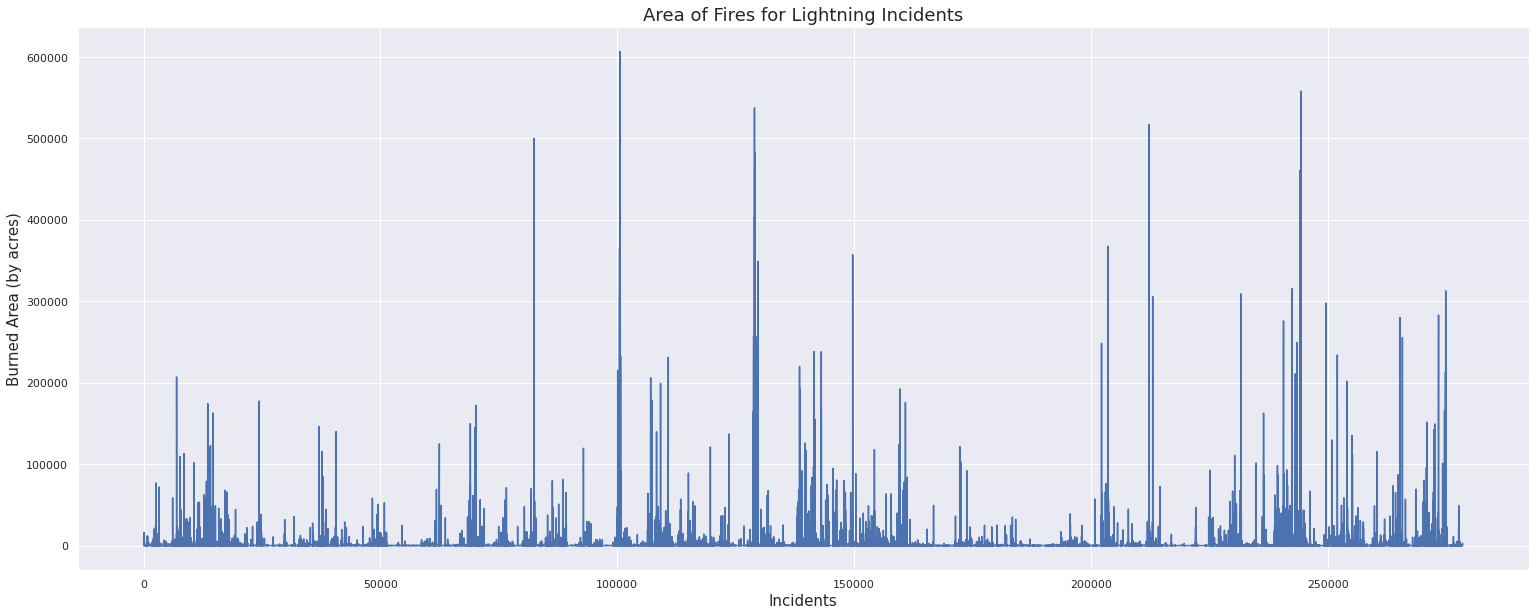

In [19]:
lightning_incidents = vis_df[vis_df['STAT_CAUSE_DESCR'] == "Lightning"]
plt.plot(np.arange(len(lightning_incidents['FIRE_SIZE'])), lightning_incidents['FIRE_SIZE'])
plt.xlabel("Incidents", fontsize=15)
plt.ylabel("Burned Area (by acres)", fontsize=15)
plt.title("Area of Fires for Lightning Incidents", fontsize=18)

In [20]:
lightning_incidents['FIRE_SIZE'].nlargest(100).head(30)

211296     606945.0
1579574    558198.3
305585     537627.0
1215267    517078.0
153705     499945.0
305684     483280.0
305642     463994.0
1578265    461047.0
305583     419884.0
305619     403993.0
1064940    367785.0
211242     365871.0
345063     357185.0
306567     349449.9
305621     344833.0
305626     320155.0
1572842    315578.8
1804783    312918.3
1471308    309200.0
211262     308120.0
1216965    306113.0
1635007    297845.0
305649     284595.0
1798586    283180.0
1734936    280141.0
1804903    276038.1
1567101    275960.0
305663     265919.9
305327     257549.0
306311     256734.1
Name: FIRE_SIZE, dtype: float64

from the graph and from top 30 area sizes we can say that outliers are those with > 320k area size.

Now we want to see if those incidents were in Alaska or another uninhibitant area:

In [21]:
lightning_incidents[lightning_incidents['FIRE_SIZE'] > 320000]["STATE"]

153705     OR
211242     AK
211296     AK
305583     AK
305585     AK
305619     AK
305621     AK
305626     AK
305642     AK
305684     AK
306567     AK
345063     UT
1064940    ID
1215267    AK
1578265    OR
1579574    OR
Name: STATE, dtype: object

We can see that most of the outliers incidents occured in Alaska.

Now we want to see the burning duration of those incidents:

In [22]:
lightning_incidents[lightning_incidents['FIRE_SIZE'] > 320000]["BURNING_DURATION_PER_DAY"]

153705     118.0
211242     142.0
211296      76.0
305583     132.0
305585     109.0
305619     126.0
305621     126.0
305626     147.0
305642     144.0
305684     105.0
306567     100.0
345063      28.0
1064940     36.0
1215267     82.0
1578265     26.0
1579574     22.0
Name: BURNING_DURATION_PER_DAY, dtype: float64

We can see that most of the outliers incidents were extinguished after 100 days, which means the fire has tremendously expanded!

Therefore, we can verify the correctness of our hypothesis.

## Number of Fires by Day of Week:

In [23]:
vis_df["DAY_OF_WEEK"] = vis_df["DAY_OF_WEEK"].apply(lambda x: {0 : "Monday", 1: "Tuesday", 2 : "Wednesday", 3 : "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}[x])

In [24]:
days = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

In [25]:
day_of_week_freq = vis_df["DAY_OF_WEEK"].value_counts()
day_of_week_freq = pd.DataFrame([day_of_week_freq[day] for day in days], index = days)[0]

Text(0, 0.5, 'Count of Fires')

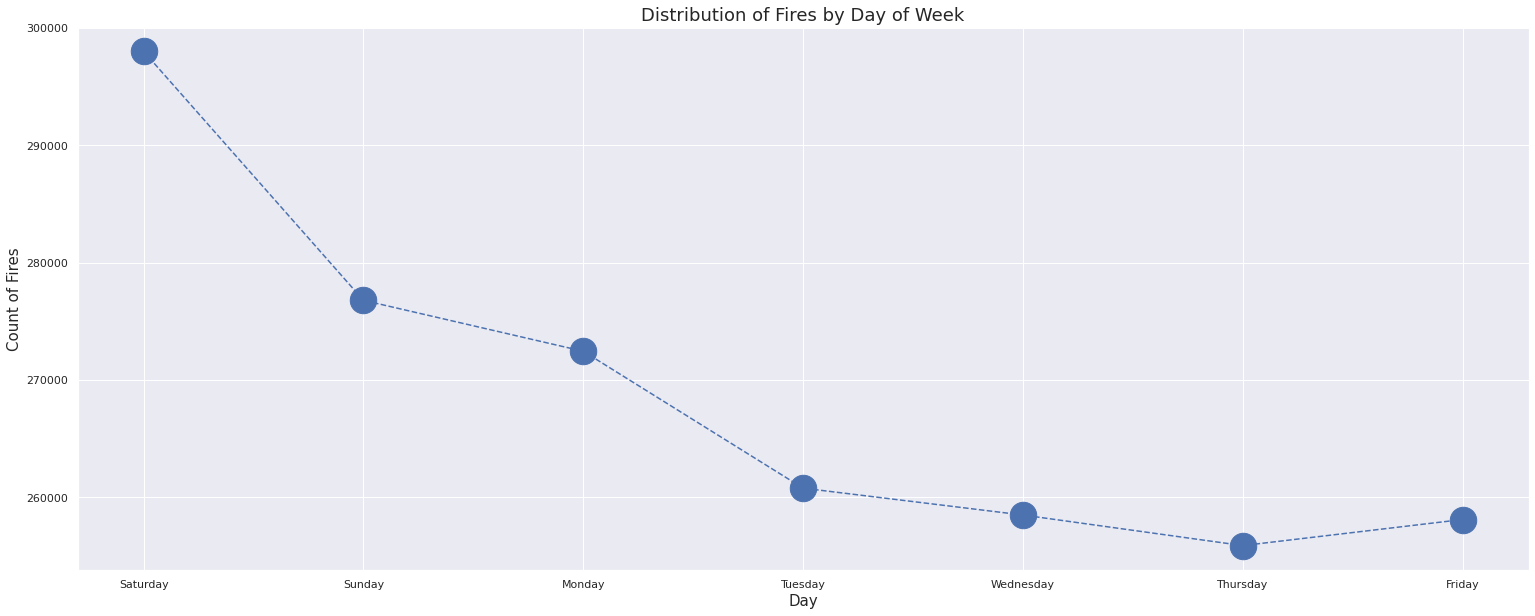

In [26]:
plt.scatter(day_of_week_freq.index, day_of_week_freq, s = 700)
day_of_week_freq.plot(linestyle='dashed')
plt.title('Distribution of Fires by Day of Week', fontsize=18)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Count of Fires', fontsize=15)

We can see that on weekends we have more incidents, which means human causes are more common.

We could assume that most of those incidents that take place on weekends are Fireworks and Campfire.

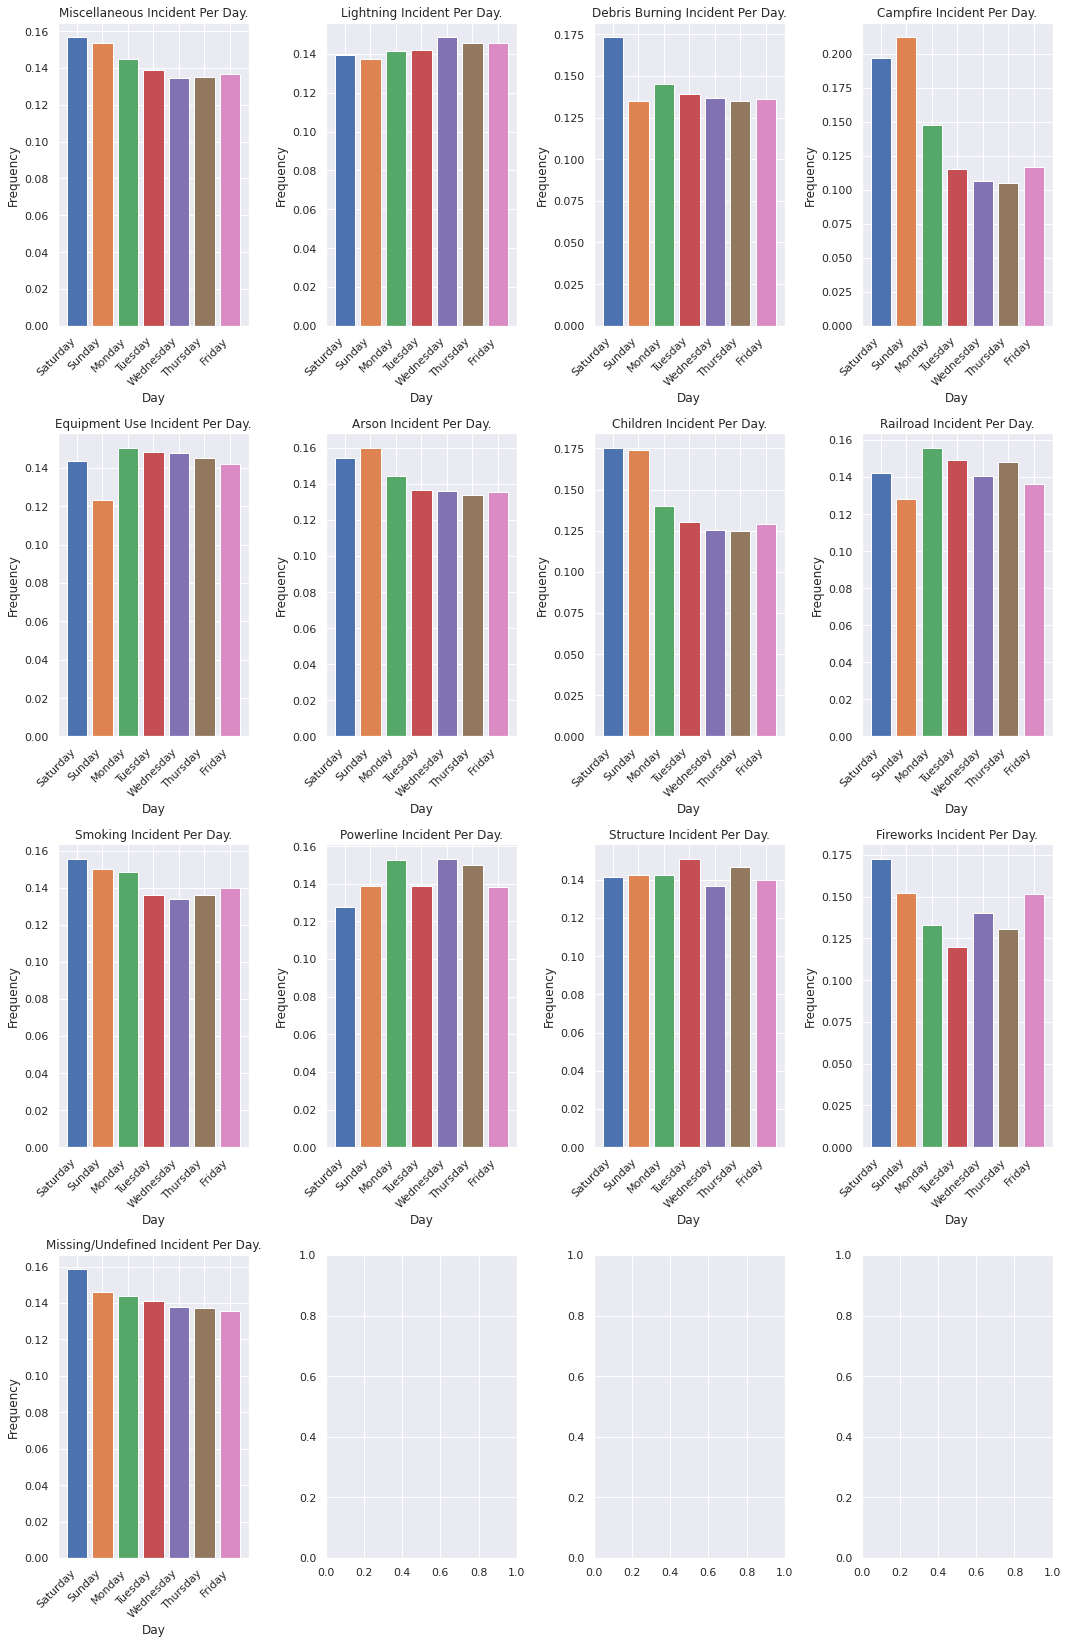

In [27]:
fig, ax = plt.subplots(4, 4, figsize=(15, 23))
for i, cause in enumerate(vis_df["STAT_CAUSE_DESCR"].unique()):
  row = i//4
  col = i%4
  temp_df = vis_df[vis_df["STAT_CAUSE_DESCR"] == cause]
  our_data = temp_df["DAY_OF_WEEK"].value_counts()
  my_dic = dict(our_data/sum(our_data))

  for day in days:
    ax[row, col].bar(day, my_dic[day])
    
  ax[row, col].set_title(cause + " Incident Per Day.")
  ax[row, col].set_xlabel("Day")
  ax[row, col].set_xticklabels(days, rotation=45, ha='right')
  ax[row, col].set_ylabel("Frequency")

fig.tight_layout() 
plt.show()


We can see that Campfire and Fireworks incidents mostly occur on weekends as we assumes.

Where Lightning causes occur on any day equally.

In a conclusion, human causes occur on specific days more frequent. Such as Fireworks and Campfire Incidents are more common on weekends. 

Considering these two factors in our predicting model we would be more successful!

## Number of Fires by Month:

In [28]:
vis_df["MONTH"] = vis_df["MONTH"].apply(lambda x: {1: "January", 2 : "February", 3 : "March", 
                                                       4: "April", 5: "May", 6: "June", 7 : "July", 8 : "August", 9 : "September", 10: "October", 11 : "November", 12: "December"}[x])

In [29]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [30]:
month_freq = vis_df["MONTH"].value_counts()
month_freq = pd.DataFrame([month_freq[month] for month in months], index = months)[0]

Text(0, 0.5, 'Count of Fires')

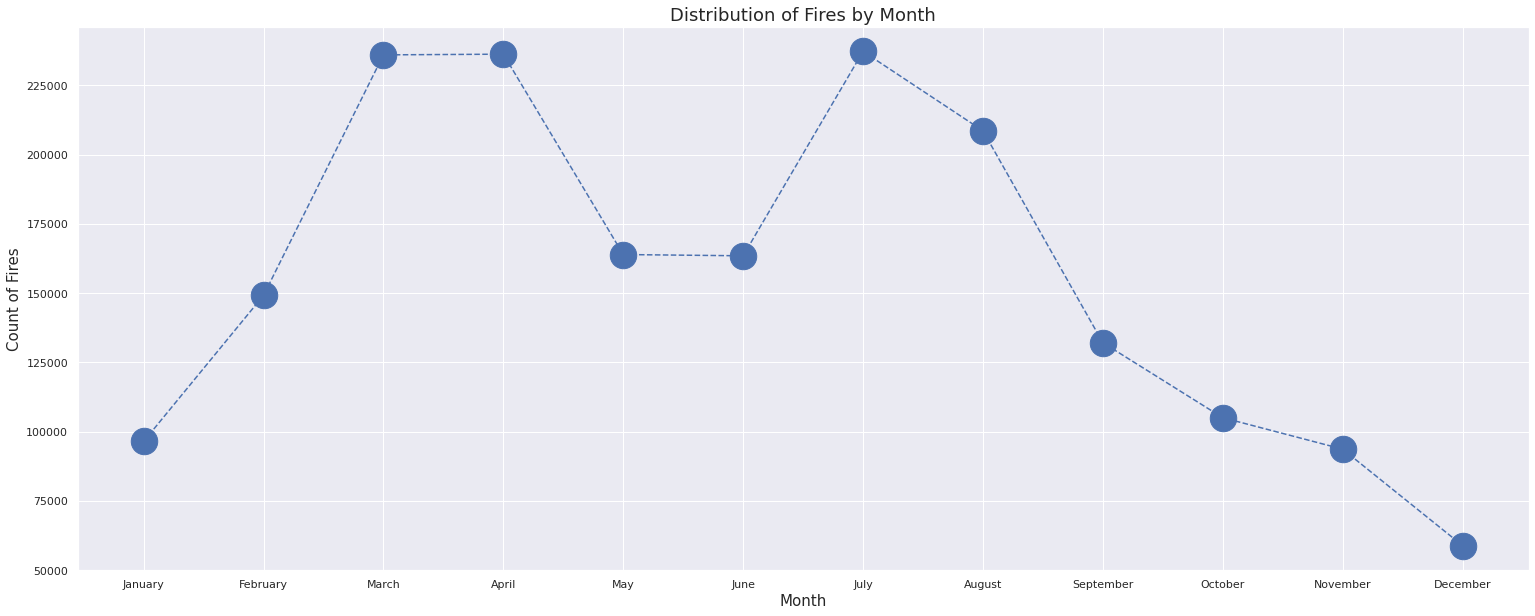

In [31]:
plt.scatter(month_freq.index, month_freq, s = 700)
month_freq.plot(linestyle='dashed')
plt.title('Distribution of Fires by Month', fontsize=18)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Count of Fires', fontsize=15)

We can see that wildfire incidents are less common in Fall-Winter (September - February)

Where in Spring-Summer, there are increase in those incidents.

Also in this case we can assume that the increase is because of campfires or equipment use. Since on Summer, people tend to go on trips such as going to park or woods where equipments / materials are more flammable.

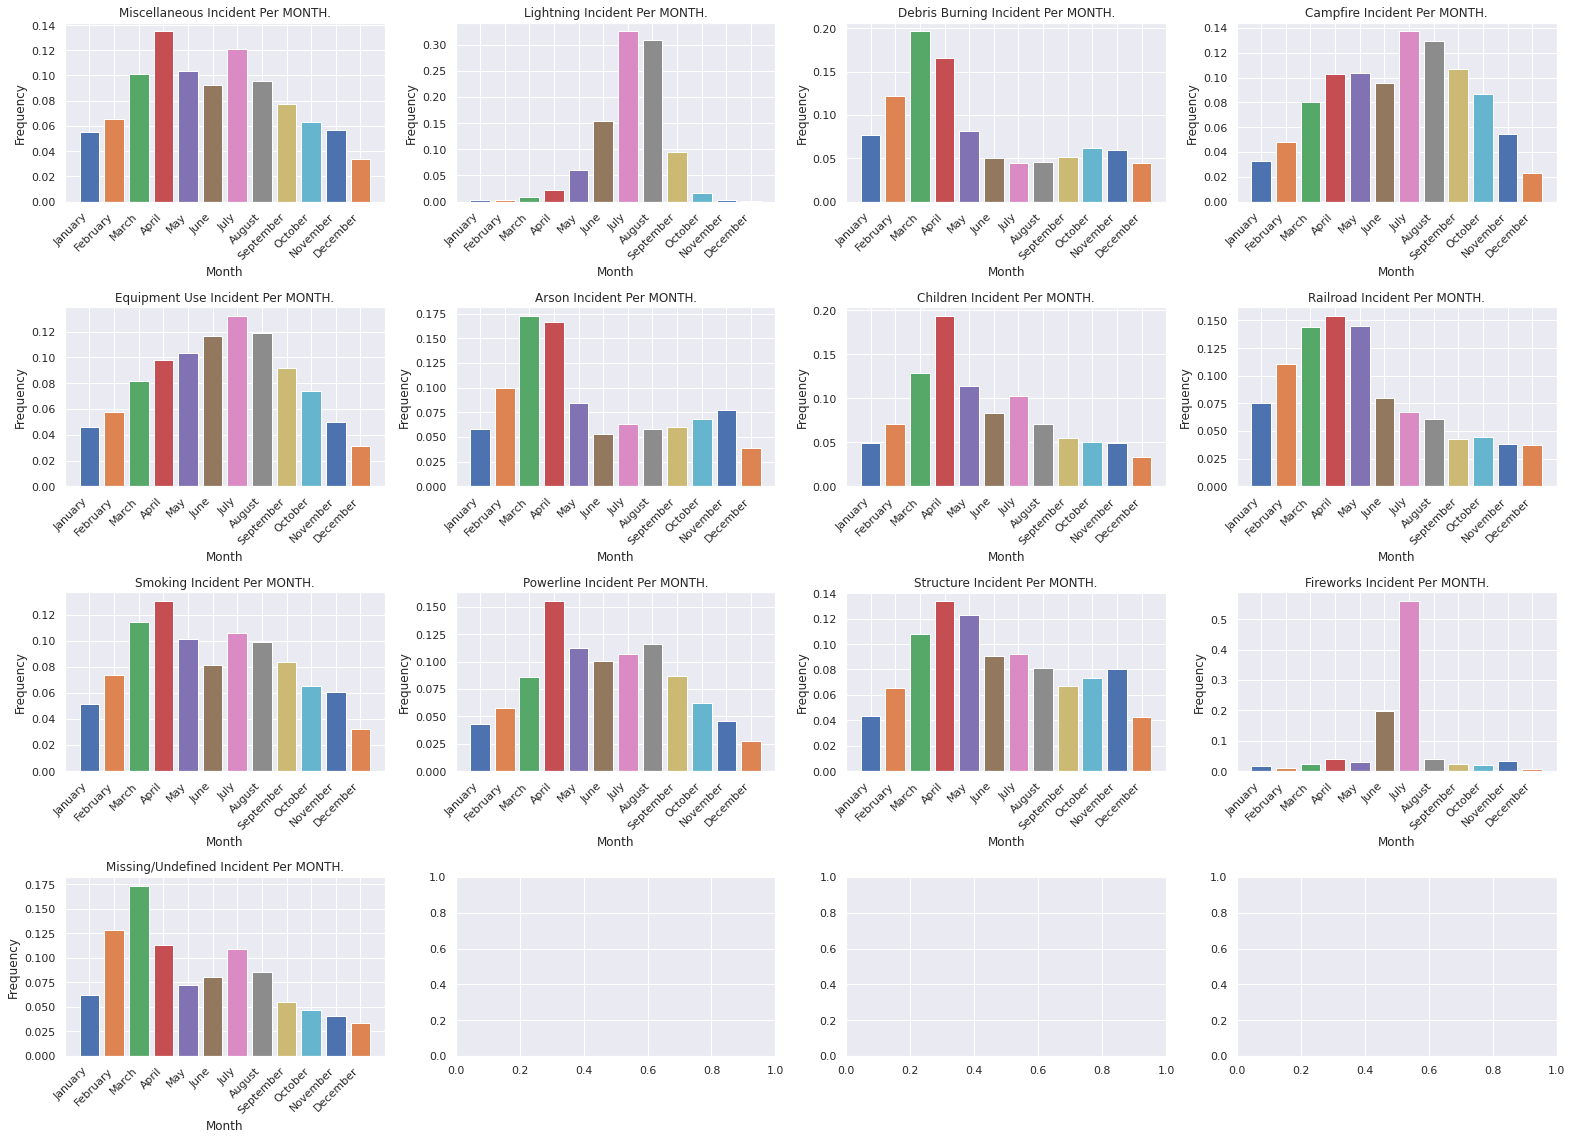

In [32]:
fig, ax = plt.subplots(4, 4, figsize=(22, 16))
for i, cause in enumerate(vis_df["STAT_CAUSE_DESCR"].unique()):
  row = i//4
  col = i%4
  temp_df = vis_df[vis_df["STAT_CAUSE_DESCR"] == cause]
  our_data = temp_df["MONTH"].value_counts()
  my_dic = dict(our_data/sum(our_data))

  for month in months:
    ax[row, col].bar(month, my_dic[month])
    
  ax[row, col].set_title(cause + " Incident Per MONTH.")
  ax[row, col].set_xlabel("Month")
  ax[row, col].set_xticklabels(months, rotation=45, ha='right')
  ax[row, col].set_ylabel("Frequency")

fig.tight_layout() 
plt.show()

We can see that 85% of the lightning causes occur in 4 sequent months.

We can see that 75% of Fireworks occur on June/July which is the annual holidays, especially 4th of July - Independence day.

We can see a lot of other features in the graphs.

As a conclusion, using Month and human cause or natural cause could really benefit us in the predicting model.

## Distribution of Fires Classes:

In [33]:
fire_by_class = vis_df.groupby(by = 'FIRE_SIZE_CLASS').agg({'OBJECTID':'count', 'FIRE_SIZE':['sum', 'max', 'mean']})
fig = px.bar(x = fire_by_class['OBJECTID'].index, 
       y = fire_by_class['OBJECTID']['count'], 
       title = 'Distribution of Fire Classes')
fig.update_layout(title_x = 0.5, 
                  xaxis_title="Fire Size Class", 
                  yaxis_title = 'Count of Fires')
fig.show()

We can see that most of Fire incidents took place in the following Classes: A and B. 

## Total Area Burned by Fire Classes:

In [34]:
fig = px.bar(x = fire_by_class['OBJECTID'].index, 
       y = fire_by_class['FIRE_SIZE']['sum'], 
       title = 'Total Area Burned by Fire Classes')
fig.update_layout(title_x = 0.5, 
                  xaxis_title="Fire Size Class", 
                  yaxis_title = 'Area Burned (By Acres)')
fig.show()

According to Fire Classes definition, the rightest class is the one with more acres burned as we can see above.

## Number of Fires by Size Class and by State:

In [35]:
def state_class_count(df):
    fires_by_state_class = df.groupby(by = ['STATE', 'FIRE_SIZE_CLASS'])['OBJECTID'].count()
    class_list = {'A':fires_by_state_class.loc[:,'A'], 
                  'B':fires_by_state_class.loc[:,'B'],
                  'C':fires_by_state_class.loc[:,'C'], 
                  'D':fires_by_state_class.loc[:,'D'], 
                  'E':fires_by_state_class.loc[:,'E'], 
                  'F':fires_by_state_class.loc[:,'F'],
                  'G':fires_by_state_class.loc[:,'G'], 
                  'TOTAL':fires_by_state_class.groupby('STATE').sum()
    }
    return pd.DataFrame(class_list)

state_class_fires = state_class_count(vis_df)
fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_fires.index,
          y = state_class_fires['G']),
    go.Bar(name = 'F',x = state_class_fires.index, 
          y = state_class_fires['F']),
    go.Bar(name = 'E',x = state_class_fires.index,
           y = state_class_fires['E']),
    go.Bar(name = 'D',x = state_class_fires.index,
           y = state_class_fires['D']),
    go.Bar(name = 'C',x = state_class_fires.index,
           y = state_class_fires['C']),
    go.Bar(name = 'B',x = state_class_fires.index,
           y = state_class_fires['B']),
    go.Bar(name = 'A',x = state_class_fires.index,
           y = state_class_fires['A'])
])

fig.update_layout(barmode='stack', 
                  width=1200,
                  height=600, 
                  title = 'Number of Fires by Size Class and by State', 
                  title_x = 0.5)
fig.show()

We can see that the biggest states have more fire incidents relatively.

We can see that CA has a lot of A incidents compared to other states.

## Acres of Burned Land Size Class and by State:

In [36]:
def size_by_state_area(df):
    fires_by_state_area = df.groupby(by = ['STATE', 'FIRE_SIZE_CLASS']).agg({'FIRE_SIZE':['sum', 'max', 'mean']})['FIRE_SIZE']
    class_list = {'A':fires_by_state_area['sum'].loc[:,'A'], 
                  'B':fires_by_state_area['sum'].loc[:,'B'],
                  'C':fires_by_state_area['sum'].loc[:,'C'], 
                  'D':fires_by_state_area['sum'].loc[:,'D'], 
                  'E':fires_by_state_area['sum'].loc[:,'E'], 
                  'F':fires_by_state_area['sum'].loc[:,'F'],
                  'G':fires_by_state_area['sum'].loc[:,'G'], 
                  'TOTAL':fires_by_state_area['sum'].groupby('STATE').sum()
    }
    return pd.DataFrame(class_list)

state_class_area = size_by_state_area(vis_df)

fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_area.index,
          y = state_class_area['G']),
    go.Bar(name = 'F',x = state_class_area.index, 
          y = state_class_area['F']),
    go.Bar(name = 'E',x = state_class_area.index,
           y = state_class_area['E']),
    go.Bar(name = 'D',x = state_class_area.index,
           y = state_class_area['D']),
    go.Bar(name = 'C',x = state_class_area.index,
           y = state_class_area['C']),
    go.Bar(name = 'B',x = state_class_area.index,
           y = state_class_area['B']),
    go.Bar(name = 'A',x = state_class_area.index,
           y = state_class_area['A'])
])

fig.update_layout(barmode='stack', 
                  width=1200,
                  height=800, 
                  title = 'Acres of Burned Land Size Class and by State', 
                  title_x = 0.5)

fig.update_xaxes(tickangle=90)
fig.show()

Alaska is again the clear leader in this pack since G fires burn huge swaths of Alaska regularly. California and Idaho then come in second and third due to their huge territories that are susceptible to large fires and have terrains that make it difficult to control

## Proportion of Burned Acres by Classes and State:

In [37]:
fig = go.Figure(data=[
    go.Bar(name = 'G',x = state_class_area.index,
          y = state_class_area['G']/state_class_area['TOTAL']),
    go.Bar(name = 'F',x = state_class_area.index, 
          y = state_class_area['F']/state_class_area['TOTAL']),
    go.Bar(name = 'E',x = state_class_area.index,
           y = state_class_area['E']/state_class_area['TOTAL']),
    go.Bar(name = 'D',x = state_class_area.index,
           y = state_class_area['D']/state_class_area['TOTAL']),
    go.Bar(name = 'C',x = state_class_area.index,
           y = state_class_area['C']/state_class_area['TOTAL']),
    go.Bar(name = 'B',x = state_class_area.index,
           y = state_class_area['B']/state_class_area['TOTAL']),
    go.Bar(name = 'A',x = state_class_area.index,
           y = state_class_area['A']/state_class_area['TOTAL'])
])
                
fig.update_layout(barmode='stack', 
                  width=1200,
                  height=600, 
                  title = 'Proportion of Burned Acres by Classes and State', 
                  title_x = 0.5)

fig.update_xaxes(tickangle=90)
fig.show()

## Count of Fire Causes by State:

In [38]:
def cause_by_state_count(df):
    cause_state_count = df.groupby(by = ['STATE', 'STAT_CAUSE_CODE'])['OBJECTID'].count()
    class_list = {'1':cause_state_count.loc[:,1], 
                  '2':cause_state_count.loc[:,2],
                  '3':cause_state_count.loc[:,3], 
                  '4':cause_state_count.loc[:,4], 
                  '5':cause_state_count.loc[:,5], 
                  '6':cause_state_count.loc[:,6],
                  '7':cause_state_count.loc[:,7], 
                  '8':cause_state_count.loc[:,8], 
                  '9':cause_state_count.loc[:,9], 
                  '10':cause_state_count.loc[:,10], 
                  '11':cause_state_count.loc[:,11], 
                  '12':cause_state_count.loc[:,12], 
                  '13':cause_state_count.loc[:,13], 
                  'TOTAL':cause_state_count.groupby('STATE').sum()
    }
    return pd.DataFrame(class_list)

cause_state_count = cause_by_state_count(vis_df)

In [39]:
fig = go.Figure(data=[
    go.Bar(name = 'Lightning',x = cause_state_count.index,
          y = cause_state_count['1']),
    go.Bar(name = 'Equipment Use',x = cause_state_count.index, 
          y = cause_state_count['2']),
    go.Bar(name = 'Smoking',x = cause_state_count.index,
           y = cause_state_count['3']),
    go.Bar(name = 'Campfire',x = cause_state_count.index,
           y = cause_state_count['4']),
    go.Bar(name = 'Debris Burning',x = cause_state_count.index,
           y = cause_state_count['5']),
    go.Bar(name = 'Railroad',x = cause_state_count.index,
           y = cause_state_count['6']),
    go.Bar(name = 'Arson',x = cause_state_count.index,
           y = cause_state_count['7']), 
    go.Bar(name = 'Children',x = cause_state_count.index,
           y = cause_state_count['8']), 
    go.Bar(name = 'Miscellaneous',x = cause_state_count.index,
           y = cause_state_count['9']), 
    go.Bar(name = 'Fireworks',x = cause_state_count.index,
           y = cause_state_count['10']), 
    go.Bar(name = 'Powerline',x = cause_state_count.index,
           y = cause_state_count['11']), 
    go.Bar(name = 'Structure',x = cause_state_count.index,
           y = cause_state_count['12']), 
    go.Bar(name = 'Missing/Undefined',x = cause_state_count.index,
           y = cause_state_count['13'])
])

fig.update_layout(barmode='stack', 
                  width=1200,
                  height=800, 
                  title = 'Count of Fire Causes by State', 
                  title_x = 0.5)
fig.update_xaxes(tickangle=90)
fig.show()

## Fire Counts by State per Year:

In [40]:
fires_by_year = vis_df.groupby(by = ['STATE', 'FIRE_YEAR']).agg({'OBJECTID':'count', 'FIRE_SIZE':['sum', 'max', 'mean']})

fires_by_year['STATE'] = fires_by_year.index.get_level_values(0)
fires_by_year['FIRE_YEAR'] = fires_by_year.index.get_level_values(1)
fires_by_year['FIRE_COUNT'] = fires_by_year['OBJECTID']['count']
fires_by_year['FIRE_SIZE_SUM_log'] = np.log10(fires_by_year['FIRE_SIZE']['sum'])
fires_by_year['FIRE_SIZE_SUM_log'] = np.log10(fires_by_year['FIRE_SIZE']['sum'])

fig = px.choropleth(data_frame = fires_by_year, 
                  locations = fires_by_year['STATE'],
                  color = 'FIRE_COUNT',
                  range_color = [0,9000],
                  locationmode = 'USA-states',
                  animation_frame = 'FIRE_YEAR')

fig.update_layout(geo_scope = 'usa', title = 'Fire Counts by State per Year', title_x=0.5)

Suprisingly, we see that areas that fire concentrations changes year over year.

In most of the years we can see that CA is leading with huge fire count relatively. This can be explained of the common lightnings and the celebrations(fireworks) done there over the year.

From 2005 TX is leading as well since its a warm/hot state over the year.

# More Preprocessing

Dropping Miscellaneous and Missing/Undefined incidents since our aim is to predict causes and not to predict that we don't know the cause:
we drop about 500k data but we still have about 1.4m Data which is enough for predicting our target.

In [41]:
new_df = new_df[new_df["STAT_CAUSE_DESCR"] != "Miscellaneous"]
new_df = new_df[new_df["STAT_CAUSE_DESCR"] != "Missing/Undefined"]

In [42]:
new_df.head()

,OBJECTID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,MONTH,DAY_OF_WEEK,CONT_MONTH,CONT_DAY_OF_WEEK,BURNING_DURATION_PER_DAY
1,2,FED,FS-FIRESTAT,FS,2004,1.0,Lightning,0.223144,0,38.933056,-120.404444,USFS,CA,5,2,5.0,2.0,0.0
2,3,FED,FS-FIRESTAT,FS,2004,5.0,Debris Burning,0.095310,0,38.984167,-120.735556,STATE OR PRIVATE,CA,5,0,5.0,0.0,0.0
3,4,FED,FS-FIRESTAT,FS,2004,1.0,Lightning,0.095310,0,38.559167,-119.913333,USFS,CA,6,0,7.0,5.0,5.0
4,5,FED,FS-FIRESTAT,FS,2004,1.0,Lightning,0.095310,0,38.559167,-119.933056,USFS,CA,6,0,7.0,5.0,5.0
5,6,FED,FS-FIRESTAT,FS,2004,1.0,Lightning,0.095310,0,38.635278,-120.103611,USFS,CA,6,2,7.0,3.0,1.0


let's initialize 

*   target y - STAT_CAUSE_CODE - which is the description but numeric.

*   label_df - which is the same as the above df but changes the features with string values to frequency. Since Frequency imputation seemed one of the great options here.

*   dummies_df - which is the same as the above df but changes the features with string values to dummies values. Since dummies values seemed one of the great options here.

we didn't consider labeling those features since they aren't ordinal features.

we created two main data frames to see which works better. But at the end we found that the work almost the same.


In [43]:
y = new_df["STAT_CAUSE_CODE"]
new_df = new_df.drop(columns=["STAT_CAUSE_DESCR", "STAT_CAUSE_CODE"])
label_df = new_df.copy()
dummies_df = new_df.copy()


loading dummies_df

In [44]:
dummies_df = pd.get_dummies(dummies_df, columns=["SOURCE_SYSTEM_TYPE", "SOURCE_SYSTEM", "NWCG_REPORTING_AGENCY", "OWNER_DESCR", "STATE"], drop_first=True)

loading label_df

In [45]:
def convert_to_freq(df, feature):
  col = df[feature] 
  col.head()
  encoder = CountFrequencyEncoder(encoding_method='frequency',
                          variables=[feature])
  encoder.fit(df) 
  dic = encoder.encoder_dict_[feature]
  df[feature].replace(dic, inplace=True)

In [46]:
convert_to_freq(label_df, "STATE")
convert_to_freq(label_df, "SOURCE_SYSTEM_TYPE")
convert_to_freq(label_df, "SOURCE_SYSTEM")
convert_to_freq(label_df, "NWCG_REPORTING_AGENCY")
convert_to_freq(label_df, "OWNER_DESCR")

adding new feature

In [47]:
vis_df["IS_WEEKEND"] = vis_df["DAY_OF_WEEK"].apply(lambda x: 1 if x in ["Saturday", "Sunday"] else 0)

In [48]:
label_df["IS_WEEKEND"] = vis_df["IS_WEEKEND"]
dummies_df["IS_WEEKEND"] = vis_df["IS_WEEKEND"]

In [49]:
label_df.head()

,OBJECTID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,MONTH,DAY_OF_WEEK,CONT_MONTH,CONT_DAY_OF_WEEK,BURNING_DURATION_PER_DAY,IS_WEEKEND
1,2,0.292189,0.139552,0.139612,2004,0.223144,0,38.933056,-120.404444,0.122263,0.089934,5,2,5.0,2.0,0.0,0
2,3,0.292189,0.139552,0.139612,2004,0.095310,0,38.984167,-120.735556,0.036591,0.089934,5,0,5.0,0.0,0.0,0
3,4,0.292189,0.139552,0.139612,2004,0.095310,0,38.559167,-119.913333,0.122263,0.089934,6,0,7.0,5.0,5.0,0
4,5,0.292189,0.139552,0.139612,2004,0.095310,0,38.559167,-119.933056,0.122263,0.089934,6,0,7.0,5.0,5.0,0
5,6,0.292189,0.139552,0.139612,2004,0.095310,0,38.635278,-120.103611,0.122263,0.089934,6,2,7.0,3.0,1.0,0


removing unused features:

ObjectId is 100% distinct - unhelpful

cont time features have 50% missing data so we removed the whole features as we couldn't think of an appropriate way to impute them - although we thought about creating a model to predict those 50% but it was complicated.

In [50]:
new_df = new_df.drop(columns=["OBJECTID"])

In [51]:
dummies_df = dummies_df.drop(columns=["CONT_MONTH", "CONT_DAY_OF_WEEK", "BURNING_DURATION_PER_DAY", "OBJECTID"])

In [52]:
label_df = label_df.drop(columns=["CONT_MONTH", "CONT_DAY_OF_WEEK", "BURNING_DURATION_PER_DAY", "OBJECTID"])

In [53]:
del new_df

In [54]:
del vis_df

# Models training:

## General cause modelling:
### Here we're trying to start with predicting whether the fire is caused by humans OR natural causes, looking at the problem at a more general scope might help us in our main target of predicting the exact cause of fire.

In [55]:
y_binary = pd.Series([cause_dict[i]['man_made'] for i in y])

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(label_df, y_binary, test_size=0.30, stratify = y_binary)
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(dummies_df, y_binary, test_size=0.30, stratify = y_binary)

In [56]:
y_binary.unique()

array([0, 1])

## Showcasing what data we have:-

In [57]:
label_df.head()

,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,MONTH,DAY_OF_WEEK,IS_WEEKEND
1,0.292189,0.139552,0.139612,2004,0.223144,0,38.933056,-120.404444,0.122263,0.089934,5,2,0
2,0.292189,0.139552,0.139612,2004,0.095310,0,38.984167,-120.735556,0.036591,0.089934,5,0,0
3,0.292189,0.139552,0.139612,2004,0.095310,0,38.559167,-119.913333,0.122263,0.089934,6,0,0
4,0.292189,0.139552,0.139612,2004,0.095310,0,38.559167,-119.933056,0.122263,0.089934,6,0,0
5,0.292189,0.139552,0.139612,2004,0.095310,0,38.635278,-120.103611,0.122263,0.089934,6,2,0


In [58]:
dummies_df.head()

,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,MONTH,DAY_OF_WEEK,SOURCE_SYSTEM_TYPE_INTERAGCY,SOURCE_SYSTEM_TYPE_NONFED,SOURCE_SYSTEM_FA-NFIRS,SOURCE_SYSTEM_FS-FIRESTAT,SOURCE_SYSTEM_FWS-FMIS,SOURCE_SYSTEM_IA-AKACC,SOURCE_SYSTEM_IA-ICS209,SOURCE_SYSTEM_ST-ALALS,SOURCE_SYSTEM_ST-ARARS,SOURCE_SYSTEM_ST-AZAZS,SOURCE_SYSTEM_ST-CACDF,SOURCE_SYSTEM_ST-COCOS,SOURCE_SYSTEM_ST-CTCTS,SOURCE_SYSTEM_ST-FLFLS,SOURCE_SYSTEM_ST-GAGAS,SOURCE_SYSTEM_ST-KYKYS,SOURCE_SYSTEM_ST-LALAS,SOURCE_SYSTEM_ST-MEMES,SOURCE_SYSTEM_ST-MIMIS,SOURCE_SYSTEM_ST-MOMOS,SOURCE_SYSTEM_ST-MSMSS,SOURCE_SYSTEM_ST-NASF,SOURCE_SYSTEM_ST-NCNCS,SOURCE_SYSTEM_ST-OKOKS,SOURCE_SYSTEM_ST-ORORS,SOURCE_SYSTEM_ST-SCSCS,SOURCE_SYSTEM_ST-SDSDS,SOURCE_SYSTEM_ST-TNTNS,SOURCE_SYSTEM_ST-TXTXS,SOURCE_SYSTEM_ST-VAVAS,SOURCE_SYSTEM_ST-WAWAS,SOURCE_SYSTEM_ST-WIWIS,SOURCE_SYSTEM_ST-WYWYS,...,STATE_ID,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_MA,STATE_MD,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_MT,STATE_NC,STATE_ND,STATE_NE,STATE_NH,STATE_NJ,STATE_NM,STATE_NV,STATE_NY,STATE_OH,STATE_OK,STATE_OR,STATE_PA,STATE_PR,STATE_RI,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY,IS_WEEKEND
1,2004,0.223144,0,38.933056,-120.404444,5,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2004,0.095310,0,38.984167,-120.735556,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2004,0.095310,0,38.559167,-119.913333,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2004,0.095310,0,38.559167,-119.933056,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2004,0.095310,0,38.635278,-120.103611,6,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
print(X_train_label.head())
print(X_train_label.shape)
X_train_label.columns

         SOURCE_SYSTEM_TYPE  SOURCE_SYSTEM  ...  DAY_OF_WEEK  IS_WEEKEND
1549184            0.705822       0.029788  ...            5           1
884371             0.705822       0.043951  ...            5           1
656718             0.705822       0.354956  ...            6           1
1695681            0.705822       0.029788  ...            5           1
817993             0.705822       0.037046  ...            3           0

[5 rows x 13 columns]
(972955, 13)


Index(['SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY',
       'FIRE_YEAR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'OWNER_DESCR', 'STATE', 'MONTH', 'DAY_OF_WEEK', 'IS_WEEKEND'],
      dtype='object')

In [60]:
y_train_label.head()

1179610    1
676450     1
530459     1
1283517    1
620557     1
dtype: int64

In [61]:
print(X_train_dummies.head())
print(X_train_dummies.shape)
X_train_dummies.columns

         FIRE_YEAR  FIRE_SIZE  FIRE_SIZE_CLASS  ...  STATE_WV  STATE_WY  IS_WEEKEND
1295317       2008   0.095310                0  ...         0         0           1
167565        2004   0.095310                0  ...         0         0           0
662032        2006   0.405465                1  ...         0         0           0
1378540       1996   2.263844                1  ...         0         0           0
234131        1999   0.095310                0  ...         0         0           1

[5 rows x 116 columns]
(972955, 116)


Index(['FIRE_YEAR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'MONTH', 'DAY_OF_WEEK', 'SOURCE_SYSTEM_TYPE_INTERAGCY',
       'SOURCE_SYSTEM_TYPE_NONFED', 'SOURCE_SYSTEM_FA-NFIRS',
       ...
       'STATE_TN', 'STATE_TX', 'STATE_UT', 'STATE_VA', 'STATE_VT', 'STATE_WA',
       'STATE_WI', 'STATE_WV', 'STATE_WY', 'IS_WEEKEND'],
      dtype='object', length=116)

In [62]:
y_train_dummies.head()

993895     1
149130     0
532258     1
1045543    1
207137     1
dtype: int64

## Starting modeling with Labels df:-

In [63]:
X = label_df

X_train = X_train_label
X_test = X_test_label
y_train = y_train_label
y_test = y_test_label

### Let's start with Dr. Matan all favourite RandomForestClassifier:

In [64]:
def model_rf(X_train, y_train):
    rf = RandomForestClassifier(n_estimators = 50, 
                                max_depth = 100, 
                                min_samples_split = 100, 
                                min_samples_leaf =40)

    rf.fit(X_train, y_train)
    return rf

rf = model_rf(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print(f'Score on testing set: {rf_score}')

Score on testing set: 0.9196080406348476


### Moving to DecesionTree model:

In [65]:
def model_decision_tree_categorical(X_train, y_train):
    model = DecisionTreeClassifier(criterion = 'gini', 
                                max_depth = 200, 
                                min_samples_split = 100, 
                                min_samples_leaf = 10)
    model.fit(X_train, y_train)
    return model

dt_cat = model_decision_tree_categorical(X_train, y_train)
dt_cat_score = dt_cat.score(X_test, y_test)
print(f'Score on testing set: {dt_cat_score}')

Score on testing set: 0.9195864569693656


#### Not bad! a percentage of 92% for our general target is great.

### Let's move to check KNN model:

In [66]:
def model_knn(X_train, y_train):
    KNC = KNeighborsClassifier(n_neighbors = 5)
    KNC.fit(X_train, y_train)

    return KNC

KNC = model_knn(X_train, y_train)
KNC_score = KNC.score(X_test, y_test)
print(f'Score on testing set: {KNC_score}')

Score on testing set: 0.9174832486774009


### Finally, a CatBoost learner might be worth it:

In [67]:
def model_catBoost(X_train, y_train):
    cB = CatBoostClassifier(iterations=1000, learning_rate=0.1,depth=3, verbose=50)
    cB.fit(X_train, y_train)

    return cB

cB = model_catBoost(X_train, y_train)
cB_score = cB.score(X_test, y_test)
print(f'Score on testing set: {cB_score}')

0:	learn: 0.6031804	total: 252ms	remaining: 4m 12s
50:	learn: 0.2657042	total: 8.12s	remaining: 2m 31s
100:	learn: 0.2503510	total: 16s	remaining: 2m 22s
150:	learn: 0.2429216	total: 23.8s	remaining: 2m 13s
200:	learn: 0.2378110	total: 31.5s	remaining: 2m 5s
250:	learn: 0.2336086	total: 39.2s	remaining: 1m 56s
300:	learn: 0.2306159	total: 46.9s	remaining: 1m 48s
350:	learn: 0.2280797	total: 55.8s	remaining: 1m 43s
400:	learn: 0.2257104	total: 1m 6s	remaining: 1m 39s
450:	learn: 0.2238067	total: 1m 14s	remaining: 1m 30s
500:	learn: 0.2221600	total: 1m 22s	remaining: 1m 21s
550:	learn: 0.2207044	total: 1m 29s	remaining: 1m 13s
600:	learn: 0.2192388	total: 1m 37s	remaining: 1m 4s
650:	learn: 0.2179940	total: 1m 45s	remaining: 56.5s
700:	learn: 0.2168813	total: 1m 53s	remaining: 48.3s
750:	learn: 0.2158821	total: 2m	remaining: 40.1s
800:	learn: 0.2149594	total: 2m 8s	remaining: 32s
850:	learn: 0.2140908	total: 2m 16s	remaining: 23.9s
900:	learn: 0.2133110	total: 2m 24s	remaining: 15.8s
950

## Moving to dummies_df:

We've ran the same models on the dummies_df. It took a lot of time!!!!!!!! more than 2hours - since it has 100+ columns. The results are almost the same.

If you'd like to check by yourself, feel free to uncomment the following code.

In [68]:
# X = dummies_df

# X_train = X_train_dummies
# X_test = X_test_dummies
# y_train = y_train_dummies
# y_test = y_test_dummies

### RandomForesTClassifier:

In [69]:
# def model_rf(X_train, y_train):
#     rf = RandomForestClassifier(n_estimators = 50, 
#                                 max_depth = 100, 
#                                 min_samples_split = 100, 
#                                 min_samples_leaf =40)

#     rf.fit(X_train, y_train)
#     return rf

# rf_d = model_rf(X_train, y_train)
# rd_d_score = rf_d.score(X_test, y_test)
# print(f'Score on testing set: {rd_d_score}')

Score on testing set: 0.9044251310608131


### DecesionTree:

In [70]:
# def model_decision_tree_categorical(X_train, y_train):
#     model = DecisionTreeClassifier(criterion = 'gini', 
#                                 max_depth = 200, 
#                                 min_samples_split = 100, 
#                                 min_samples_leaf = 10)
#     model.fit(X_train, y_train)
#     return model

# dt_cat_d = model_decision_tree_categorical(X_train, y_train)
# dt_cat_score_d = dt_cat_d.score(X_test, y_test)
# print(f'Score on testing set: {dt_cat_score_d}')

Score on testing set: 0.9200469084996474


### KNN:

In [72]:
# def model_knn(X_train, y_train):
#     KNC = KNeighborsClassifier(n_neighbors = 5)
#     KNC.fit(X_train, y_train)

#     return KNC

# KNC_d = model_knn(X_train, y_train)
# KNC_d_score = KNC_d.score(X_test, y_test)
# print(f'Score on testing set: {KNC_d_score}')

### CatBoost:

In [ ]:
# def model_catBoost(X_train, y_train):
#     cB = CatBoostClassifier(iterations=1000, learning_rate=0.1,depth=3, verbose=50)
#     cB.fit(X_train, y_train)

#     return cB

# cB_d = model_catBoost(X_train, y_train)
# cB_d_score = cB_d.score(X_test, y_test)
# print(f'Score on testing set: {cB_d_score}')

## Discussing Results:
### Here, we'll post the results of the general modeling, specifically, we'll calculate ROC & AUC metrics for each model.

A reminder, here are the results [label_df score  ,,  dummies_df score]:

In [ ]:
# print("RandomForest classifier: [ " + str(rf_score) + "   " + str(rd_d_score) + " ]")
# print("DecesionTree classifier: [ " + str(dt_cat_score) + "   " + str(dt_cat_score_d) + " ]")
# print("CatBoost classifier: [ " + str(KNC_score) + "   " + str(KNC_d_score) + " ]")
# print("KNN classifier: [ " + str(cB_score) + "   " + str(cB_d_score) + " ]")

In [73]:
print("RandomForest classifier: [ " + str(rf_score) + " ]")
print("DecesionTree classifier: [ " + str(dt_cat_score) + " ]")
print("CatBoost classifier: [ " + str(KNC_score) + " ]")
print("KNN classifier: [ " + str(cB_score) + " ]")

RandomForest classifier: [ 0.9196080406348476 ]
DecesionTree classifier: [ 0.9195864569693656 ]
CatBoost classifier: [ 0.9174832486774009 ]
KNN classifier: [ 0.9145238883213185 ]


In [74]:
models_names = ["RandomForestClassifier", "DecesionTree", "K-Nearest Neighbours", "CatBoost"]
i=0

#### Label_df:

RandomForestClassifier


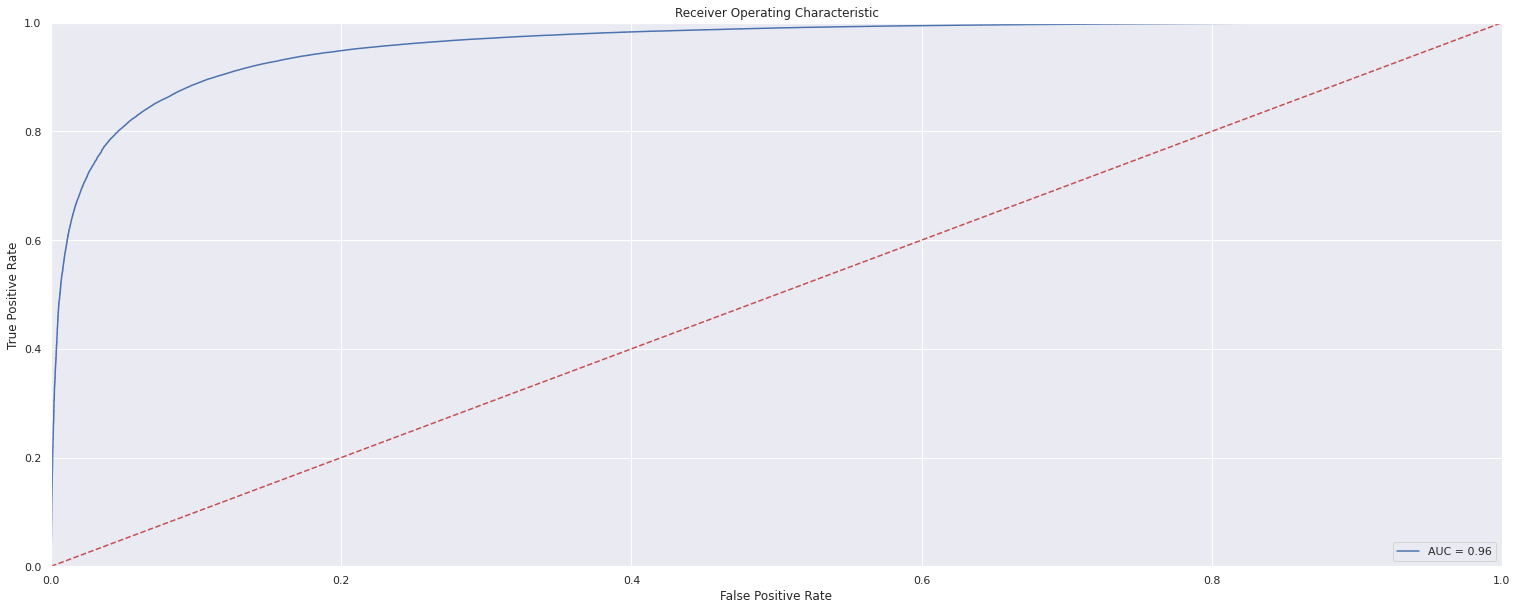




DecesionTree


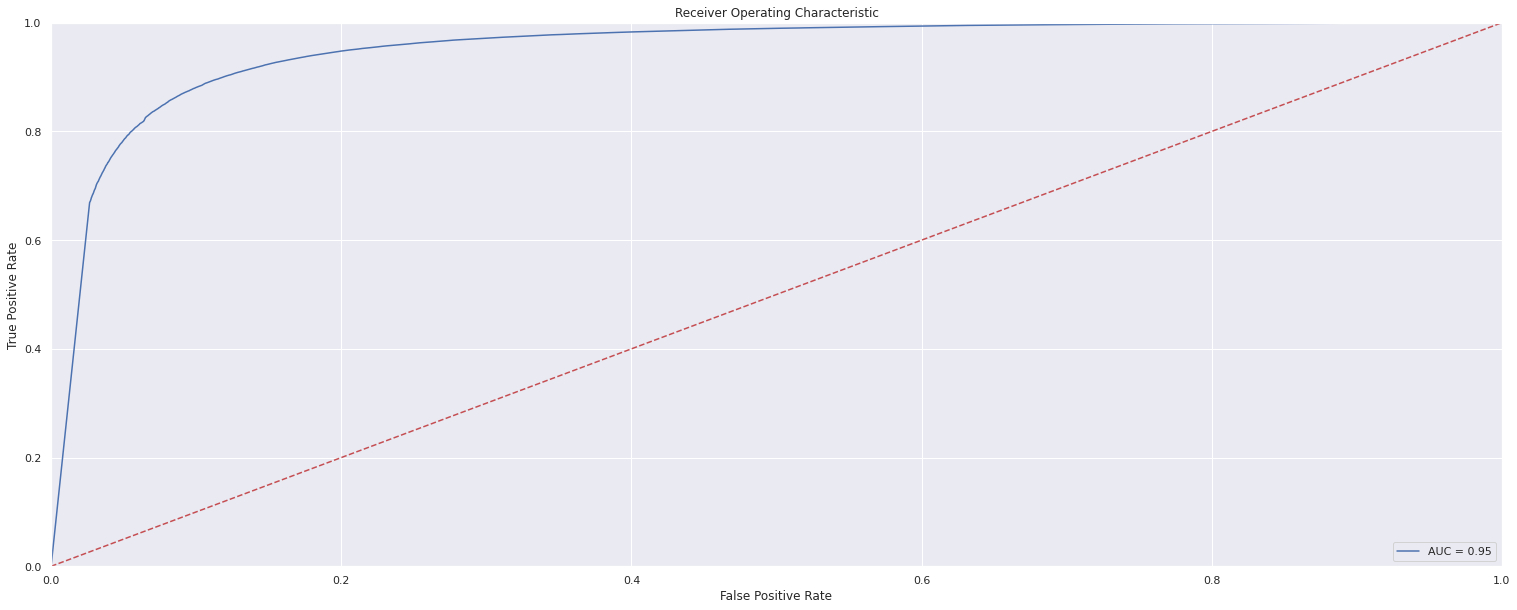




K-Nearest Neighbours


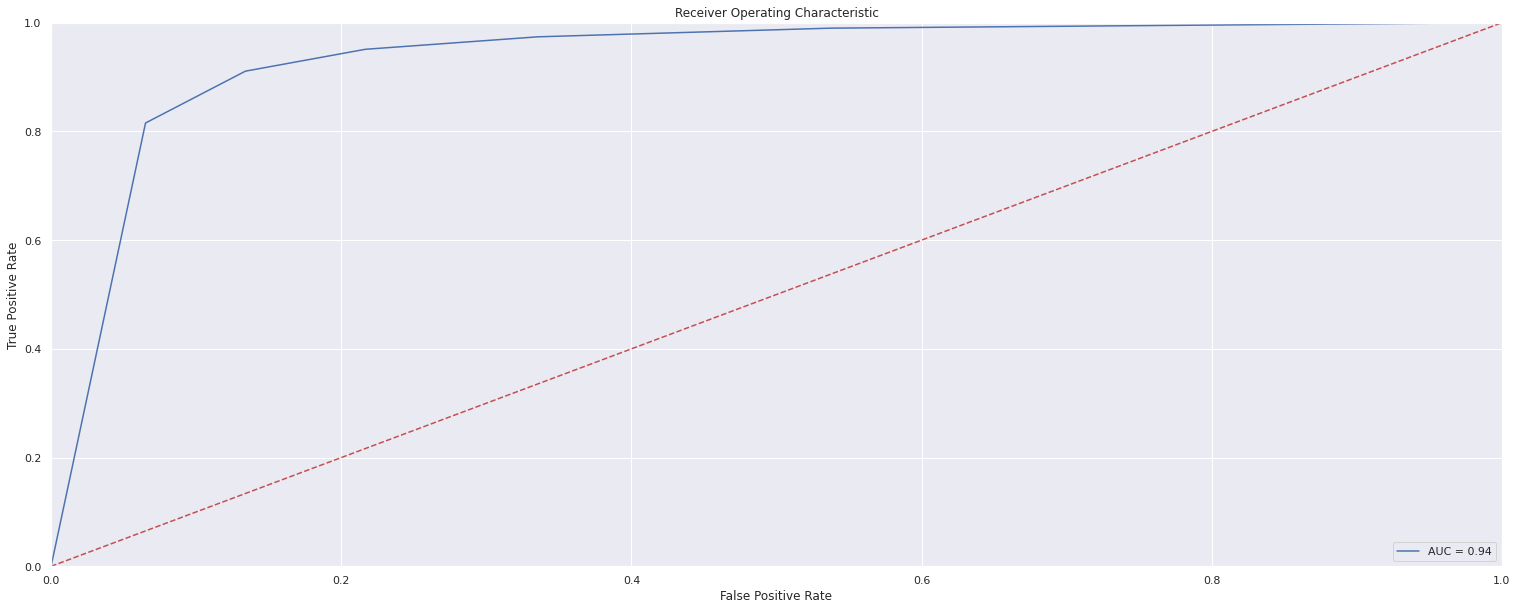




CatBoost


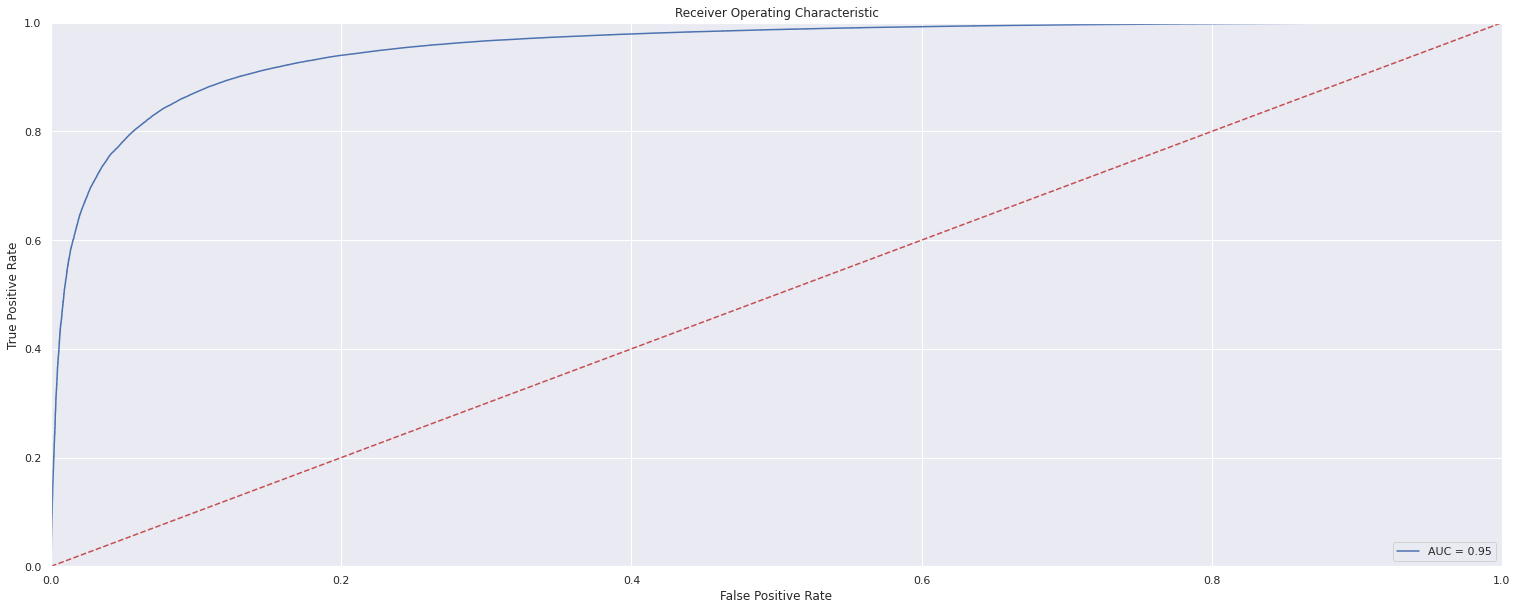

In [75]:
for model in [rf, dt_cat, KNC, cB]:
    print(models_names[i])
    i = i+1
    probs = model.predict_proba(X_test_label)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test_label, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("\n\n")

#### Dummies_df:

In [ ]:
# i=0
# for model in [rf_d, dt_cat_d, KNC_d, cB_d]:
#     print(models_names[i])
#     i = i+1
#     probs = model.predict_proba(X_test_dummies)
#     preds = probs[:,1]
#     fpr, tpr, threshold = metrics.roc_curve(y_test_dummies, preds)
#     roc_auc = metrics.auc(fpr, tpr)
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
#     print("\n\n")

In [77]:
# del rf
# del dt_cat
# del KNC
# del cB

# # del rf_d
# # del dt_cat_d
# # del KNC_d
# # del cB_d

# Exact cause modeling:

#### Again, showcasing our data:

In [78]:
label_df

,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,MONTH,DAY_OF_WEEK,IS_WEEKEND
1,0.292189,0.139552,0.139612,2004,0.223144,0,38.933056,-120.404444,0.122263,0.089934,5,2,0
2,0.292189,0.139552,0.139612,2004,0.095310,0,38.984167,-120.735556,0.036591,0.089934,5,0,0
3,0.292189,0.139552,0.139612,2004,0.095310,0,38.559167,-119.913333,0.122263,0.089934,6,0,0
4,0.292189,0.139552,0.139612,2004,0.095310,0,38.559167,-119.933056,0.122263,0.089934,6,0,0
5,0.292189,0.139552,0.139612,2004,0.095310,0,38.635278,-120.103611,0.122263,0.089934,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880451,0.705822,0.040158,0.707646,2015,0.693147,1,38.644183,-120.863673,0.036591,0.089934,6,5,1
1880452,0.705822,0.040158,0.707646,2015,0.113329,0,34.163117,-118.693303,0.036591,0.089934,4,1,0
1880453,0.705822,0.040158,0.707646,2015,0.113329,0,34.278180,-118.621180,0.036591,0.089934,7,1,0
1880457,0.705822,0.040158,0.707646,2015,0.693147,1,40.588583,-123.069617,0.036591,0.089934,9,2,0


In [79]:
dummies_df

,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,MONTH,DAY_OF_WEEK,SOURCE_SYSTEM_TYPE_INTERAGCY,SOURCE_SYSTEM_TYPE_NONFED,SOURCE_SYSTEM_FA-NFIRS,SOURCE_SYSTEM_FS-FIRESTAT,SOURCE_SYSTEM_FWS-FMIS,SOURCE_SYSTEM_IA-AKACC,SOURCE_SYSTEM_IA-ICS209,SOURCE_SYSTEM_ST-ALALS,SOURCE_SYSTEM_ST-ARARS,SOURCE_SYSTEM_ST-AZAZS,SOURCE_SYSTEM_ST-CACDF,SOURCE_SYSTEM_ST-COCOS,SOURCE_SYSTEM_ST-CTCTS,SOURCE_SYSTEM_ST-FLFLS,SOURCE_SYSTEM_ST-GAGAS,SOURCE_SYSTEM_ST-KYKYS,SOURCE_SYSTEM_ST-LALAS,SOURCE_SYSTEM_ST-MEMES,SOURCE_SYSTEM_ST-MIMIS,SOURCE_SYSTEM_ST-MOMOS,SOURCE_SYSTEM_ST-MSMSS,SOURCE_SYSTEM_ST-NASF,SOURCE_SYSTEM_ST-NCNCS,SOURCE_SYSTEM_ST-OKOKS,SOURCE_SYSTEM_ST-ORORS,SOURCE_SYSTEM_ST-SCSCS,SOURCE_SYSTEM_ST-SDSDS,SOURCE_SYSTEM_ST-TNTNS,SOURCE_SYSTEM_ST-TXTXS,SOURCE_SYSTEM_ST-VAVAS,SOURCE_SYSTEM_ST-WAWAS,SOURCE_SYSTEM_ST-WIWIS,SOURCE_SYSTEM_ST-WYWYS,...,STATE_ID,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_MA,STATE_MD,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_MT,STATE_NC,STATE_ND,STATE_NE,STATE_NH,STATE_NJ,STATE_NM,STATE_NV,STATE_NY,STATE_OH,STATE_OK,STATE_OR,STATE_PA,STATE_PR,STATE_RI,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY,IS_WEEKEND
1,2004,0.223144,0,38.933056,-120.404444,5,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2004,0.095310,0,38.984167,-120.735556,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2004,0.095310,0,38.559167,-119.913333,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2004,0.095310,0,38.559167,-119.933056,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2004,0.095310,0,38.635278,-120.103611,6,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880451,2015,0.693147,1,38.644183,-120.863673,6,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1880452,2015,0.113329,0,34.163117,-118.693303,4,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1880453,2015,0.113329,0,34.278180,-118.621180,7,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1880457,2015,0.693147,1,40.588583,-123.069617,9,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
y

1          1.0
2          5.0
3          1.0
4          1.0
5          1.0
          ... 
1880451    2.0
1880452    5.0
1880453    8.0
1880457    7.0
1880458    1.0
Name: STAT_CAUSE_CODE, Length: 1389937, dtype: float64

### Re-configuring our train_test_split for the y with multiple causes:

the same thing about the dummies_df goes here ... 

In [81]:
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(label_df, y, test_size=0.30, stratify = y_binary)
# X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(dummies_df, y, test_size=0.30, stratify = y_binary)

## Modelling:

### Label_df:-


In [82]:
X = label_df

X_train = X_train_label
X_test = X_test_label
y_train = y_train_label
y_test = y_test_label

##### In the previous modelling, KNN gave the best result, so let's start with that:-

#### KNN:

In [83]:
def model_knn_G(X_train, y_train):
    KNC = KNeighborsClassifier(n_neighbors = 4)
    KNC.fit(X_train, y_train)

    return KNC

KNC_G = model_knn_G(X_train, y_train)
KNC_score_G = KNC_G.score(X_test, y_test)
print(f'Score on testing set: {KNC_score_G}')

Score on testing set: 0.5379225002518094


#### DesicionTree was good too, let's check it out:

In [84]:
def model_decision_tree_categorical_G(X_train, y_train):
    model = DecisionTreeClassifier(criterion = 'gini', 
                                max_depth = 200, 
                                min_samples_split = 100, 
                                min_samples_leaf = 10)
    model.fit(X_train, y_train)
    return model

dt_cat_G = model_decision_tree_categorical_G(X_train, y_train)
dt_cat_score_G = dt_cat_G.score(X_test, y_test)
print(f'Score on testing set: {dt_cat_score_G}')

Score on testing set: 0.5909655572662609


#### Let's try optimizing hyperparamters via GridSearch:

In [87]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

params = {
    'max_depth' : [100, 90, 110],
    'min_samples_split' : [100,150,180],
    'min_samples_leaf' : [30,40,50],
}

def model_GridSearch_DecisionTree(X_train, y_train, params):
    model = GridSearchCV(DecisionTreeClassifier(random_state = 0), 
                        params,
                        cv = 5, 
                        verbose = 1, n_jobs=n_cpu)
    model.fit(X_train,y_train)
    return model

grid = model_GridSearch_DecisionTree(X_train, y_train, params)
print(grid.best_estimator_)
print(grid.best_params_)
print()
grid_score_G = grid.score(X_test, y_test)
print(f'Score on testing set: {grid_score_G}')

Number of CPUs in the system: 2
Fitting 5 folds for each of 27 candidates, totalling 135 fits
DecisionTreeClassifier(max_depth=100, min_samples_leaf=50,
                       min_samples_split=100, random_state=0)
{'max_depth': 100, 'min_samples_leaf': 50, 'min_samples_split': 100}

Score on testing set: 0.5919368222129492


#### To sum up the scores results:

In [106]:
print("KNN classifier: [ " + str(KNC_score_G) + " ]")
print("DecesionTree classifier: [ " + str(dt_cat_score_G) + " ]")
print("GridSearch (On DecisionTrees) classifier: [ " + str(grid_score_G) + " ]")

KNN classifier: [ 0.5379225002518094 ]
DecesionTree classifier: [ 0.5909655572662609 ]
GridSearch (On DecisionTrees) classifier: [ 0.5919368222129492 ]


## Calculating ROC & AUC metrics:

In [105]:
models_names = ["KNN classifier", "DecesionTree classifier", "GridSearch"]
i=0
for model in [KNC_G, dt_cat_G, grid]:
    print("** " + models_names[i] + " **")

    y_prob = model.predict_proba(X_test)
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    print("\n\n")

    i = i+1


** KNN classifier **
One-vs-One ROC AUC scores:
0.721025 (macro),
0.748135 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.730278 (macro),
0.785705 (weighted by prevalence)



** DecesionTree classifier **
One-vs-One ROC AUC scores:
0.823369 (macro),
0.838327 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.843488 (macro),
0.855966 (weighted by prevalence)



** GridSearch **
One-vs-One ROC AUC scores:
0.827988 (macro),
0.842214 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.848427 (macro),
0.858577 (weighted by prevalence)



